## Import Libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import squarify 
%matplotlib inline

## Load Dataset
### California Housing Dataset

In [60]:
California = pd.read_csv('California Housing.csv')
pd.set_option('display.max_columns', None)
California.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


## Dataset Profiling

In [61]:
print("Dataset dimension :", California.ndim)
print("Dataset shape :", California.shape)
print("Dataset size :", California.size)

Dataset dimension : 2
Dataset shape : (20640, 10)
Dataset size : 206400


In [62]:
California_types = California.dtypes.reset_index()
California_types.columns = ['Features','Data Type']
California_types

,Features,Data Type
0,longitude,float64
1,latitude,float64
2,housing_median_age,float64
3,total_rooms,float64
4,total_bedrooms,float64
5,population,float64
6,households,float64
7,median_income,float64
8,median_house_value,float64
9,ocean_proximity,object


## Dataset Missing and Blank Values Check

In [5]:
missing_data = California.isnull().sum().reset_index()
missing_data.columns = ['Features','Missing Values']
blank_data = California.apply(lambda x : x == ' ').sum().reset_index()
blank_data.columns = ['Features','Blank Values']
merged_data = pd.merge(missing_data, blank_data, on=['Features'])
merged_data['Filling Factor'] = (California.shape[0]-missing_data['Missing Values'] + California.shape[0]-blank_data['Blank Values'])/California.shape[0]*50
merged_data.sort_values(by='Filling Factor',ascending=True)

,Features,Missing Values,Blank Values,Filling Factor
4,total_bedrooms,207,0,99.498547
0,longitude,0,0,100.000000
1,latitude,0,0,100.000000
2,housing_median_age,0,0,100.000000
3,total_rooms,0,0,100.000000
5,population,0,0,100.000000
6,households,0,0,100.000000
7,median_income,0,0,100.000000
8,median_house_value,0,0,100.000000
9,ocean_proximity,0,0,100.000000


### Data Cleaning : Replacing Missing Values with Median

In [6]:
median_rooms = California['total_bedrooms'].median()
California['total_bedrooms'] = California['total_bedrooms'].fillna(value=median_rooms)
fill_data = California.isna().sum().reset_index()
fill_data.columns = ['Features','Missing Values']
fill_data['Filling Factor'] = (California.shape[0]-fill_data['Missing Values'])/California.shape[0]*100
fill_data

,Features,Missing Values,Filling Factor
0,longitude,0,100.0
1,latitude,0,100.0
2,housing_median_age,0,100.0
3,total_rooms,0,100.0
4,total_bedrooms,0,100.0
5,population,0,100.0
6,households,0,100.0
7,median_income,0,100.0
8,median_house_value,0,100.0
9,ocean_proximity,0,100.0


## Take a Look at Basic Data Structure

In [7]:
California.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,536.838857,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,419.391878,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,297.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,643.250000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [8]:
California['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

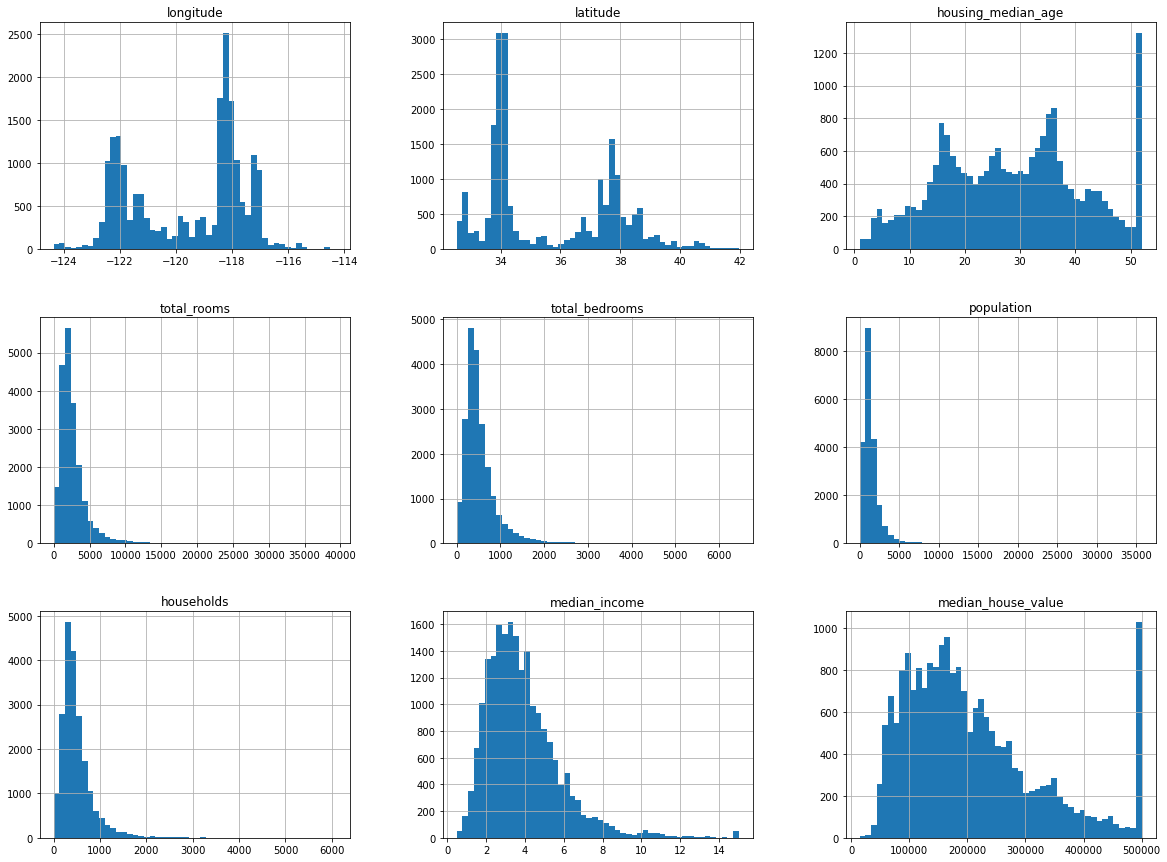

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
California.hist(bins=50, figsize=(20,15))
plt.show()

### Creating Median Income Categories

<AxesSubplot:>

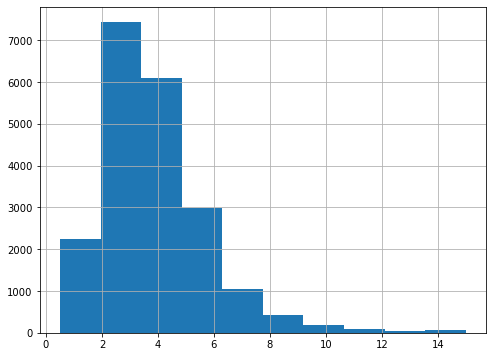

In [10]:
California['median_income'].hist(figsize=(8,6))

In [11]:
California["income_cat"] = pd.cut(California["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

California['income_cat'].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

<AxesSubplot:>

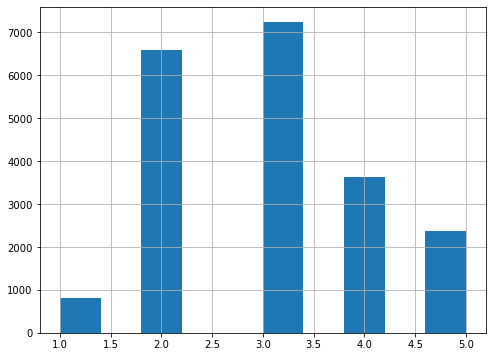

In [12]:
California['income_cat'].hist(figsize=(8,6))

### Creating Stratifiedsplit Test and Train set

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=50)
for train_index, test_index in split.split(California, California["income_cat"]):
    strat_train_set = California.loc[train_index]
    strat_test_set = California.loc[test_index]

### Comparing Stratified Test with Fulldataset

In [14]:
stt1 = (strat_test_set["income_cat"].value_counts() / len(strat_test_set)).reset_index()
stt1.columns = ['Index','Ratio Test']
stt2 = (California["income_cat"].value_counts() / len(California)).reset_index()
stt2.columns = ['Index', 'Ratio Fulldataset']
merged_data2 = pd.merge(stt1, stt2, on=['Index'])
merged_data2

,Index,Ratio Test,Ratio Fulldataset
0,3,0.350533,0.350581
1,2,0.318798,0.318847
2,4,0.176357,0.176308
3,5,0.114583,0.114438
4,1,0.039729,0.039826


In [15]:
# Dropping the income categories feature
# because we already know that test set is preety much representative of full data
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Data Exploration

In [16]:
# Using the stratified train as our new dataset for training model
California = strat_train_set.copy()

### Visualizing Geographical Data

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

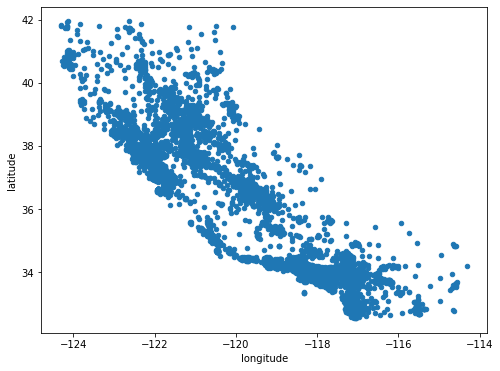

In [17]:
California.plot(kind="scatter", x="longitude", y="latitude", figsize=(8,6))

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

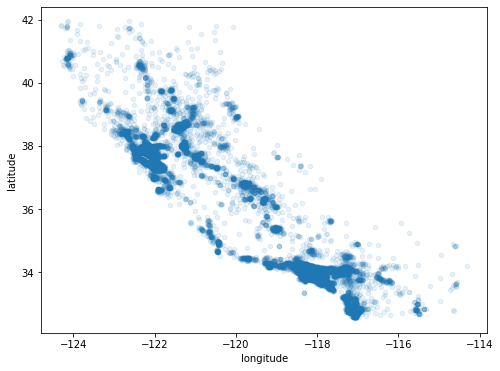

In [18]:
California.plot(kind="scatter", x="longitude", y="latitude",alpha = 0.1, figsize=(8,6))

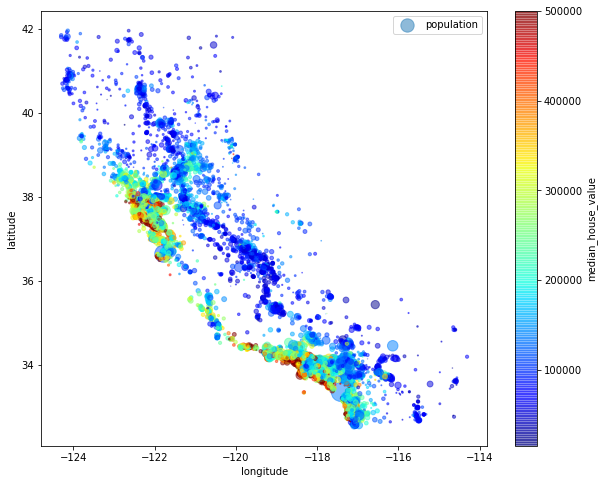

In [19]:
California.plot(kind="scatter", x="longitude", y="latitude", alpha=0.5,
             s=California["population"]/100, label="population", figsize=(10,8),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()

### Correlations with Target Feature

In [20]:
corr_matrix = California.corr()
corr_medhouse = corr_matrix["median_house_value"].sort_values(ascending=False).reset_index()
corr_medhouse.columns = ['Features','Correlation Value']
print('Correlation features with median_house_value')
corr_medhouse.sort_values(by='Correlation Value',ascending=False)

Correlation features with median_house_value


,Features,Correlation Value
0,median_house_value,1.000000
1,median_income,0.686930
2,total_rooms,0.137060
3,housing_median_age,0.103783
4,households,0.066502
5,total_bedrooms,0.052551
6,population,-0.024807
7,longitude,-0.048513
8,latitude,-0.140663


(0.0, 16.0, 0.0, 550000.0)

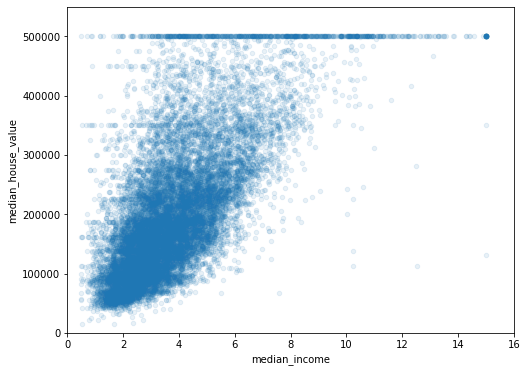

In [21]:
California.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1,figsize=(8,6))
plt.axis([0, 16, 0, 550000])

### Feature Engineering Combination

In [22]:
California['rooms_per_household'] = California['total_rooms']/California['households']
California['bedrooms_per_household'] = California['total_bedrooms']/California['households']
California['pops_per_household'] = California['population']/California['households']
California["bedrooms_per_room"] = California["total_bedrooms"]/California["total_rooms"]
California.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_household,pops_per_household,bedrooms_per_room
17055,-122.25,37.47,35.0,3183.0,515.0,1313.0,487.0,5.9062,383200.0,NEAR OCEAN,6.535934,1.057495,2.696099,0.161797
4004,-118.61,34.15,32.0,4491.0,815.0,1696.0,749.0,4.9102,319100.0,<1H OCEAN,5.995995,1.088117,2.264352,0.181474
3939,-118.58,34.21,27.0,2209.0,353.0,1034.0,344.0,4.7125,250900.0,<1H OCEAN,6.421512,1.026163,3.005814,0.159801
1669,-122.23,38.06,52.0,1350.0,266.0,490.0,257.0,3.1250,171100.0,NEAR BAY,5.252918,1.035019,1.906615,0.197037
17938,-121.94,37.34,29.0,3377.0,853.0,1674.0,792.0,3.4233,229300.0,<1H OCEAN,4.263889,1.077020,2.113636,0.252591


In [23]:
corr_matrix = California.corr()
corr_medhouse2 = corr_matrix["median_house_value"].sort_values(ascending=False).reset_index()
corr_medhouse2.columns = ['Features','Correlation Value']
print('Correlation features with median_house_value')
corr_medhouse2.sort_values(by='Correlation Value',ascending=False)

Correlation features with median_house_value


,Features,Correlation Value
0,median_house_value,1.000000
1,median_income,0.686930
2,rooms_per_household,0.151308
3,total_rooms,0.137060
4,housing_median_age,0.103783
5,households,0.066502
6,total_bedrooms,0.052551
7,population,-0.024807
8,pops_per_household,-0.027231
9,bedrooms_per_household,-0.037742


In [24]:
California.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_household,pops_per_household,bedrooms_per_room
count,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.00000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.572644,35.633534,28.718387,2639.905584,537.722626,1430.41806,500.894985,3.867919,207206.569222,5.427352,1.100999,3.070376,0.213823
std,2.002382,2.134432,12.603393,2182.949227,419.645447,1144.26038,382.509901,1.895831,115323.889433,2.565009,0.548704,10.930252,0.066463
min,-124.300000,32.540000,1.000000,2.000000,1.000000,3.00000,1.000000,0.499900,14999.000000,0.846154,0.283019,0.692308,0.042369
25%,-121.800000,33.940000,18.000000,1453.000000,298.000000,791.00000,281.000000,2.562500,120100.000000,4.441216,1.005318,2.426883,0.175160
50%,-118.500000,34.260000,29.000000,2131.000000,435.000000,1166.00000,410.000000,3.538500,180050.000000,5.228400,1.048256,2.817751,0.203044
75%,-118.010000,37.720000,37.000000,3137.000000,644.000000,1734.00000,606.000000,4.739700,265000.000000,6.042097,1.099536,3.283439,0.240000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.00000,6082.000000,15.000100,500001.000000,141.909091,34.066667,1243.333333,2.824675


## Prepare Data for Machine Learning Alogrithm

In [25]:
California = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
California_labels = strat_train_set["median_house_value"].copy()

### Splitting Numerical and Categorical Features

In [26]:
California_num = California.drop("ocean_proximity", axis=1)
# alternatively: housing_num = housing.select_dtypes(include=[np.number])

### Handling Text / Categorical Features

In [27]:
California_cat = California[["ocean_proximity"]]
California_cat.head(10)

,ocean_proximity
17055,NEAR OCEAN
4004,<1H OCEAN
3939,<1H OCEAN
1669,NEAR BAY
17938,<1H OCEAN
15041,<1H OCEAN
9807,NEAR OCEAN
1910,INLAND
7926,<1H OCEAN
15921,NEAR BAY


In [28]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
California_cat_1hot = cat_encoder.fit_transform(California_cat)
California_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [29]:
# Or Alternatiely you can set sparse to False 
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse=False)
California_cat_2hot = cat_encoder.fit_transform(California_cat)
California_cat_2hot

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Custom Pipeline Transformation

In [30]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

num_attribs = list(California_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

California_prepared = full_pipeline.fit_transform(California)

In [31]:
California_prepared

array([[-1.33712633,  0.86042624,  0.4984216 , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.48076378, -0.69506988,  0.26038327, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.49574639, -0.6669585 , -0.1363473 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.55567683, -0.75129263,  0.81580606, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.94023051, -0.97618363, -2.04065401, ...,  0.        ,
         0.        ,  0.        ],
       [-0.01865658,  0.61210909, -1.16784677, ...,  0.        ,
         0.        ,  0.        ]])

## Select and Train Model

### Linear Regression Model

In [32]:
# Choosing Model
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(California_prepared, California_labels)

LinearRegression()

In [33]:
# Model Evaluation with RMSE and MAE Metric

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

California_predictions = lin_reg.predict(California_prepared)
lin_mse = mean_squared_error(California_labels, California_predictions)
lin_rmse = np.sqrt(lin_mse)
print('Linear Reg. RMSE :',lin_rmse)

lin_mae = mean_absolute_error(California_labels, California_predictions)
print('Linear Reg. MAE :',lin_mae)

Linear Reg. RMSE : 68777.12503644277
Linear Reg. MAE : 49831.72275763095


### Decision Tree Regression Model

In [34]:
# Choosing Model
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=50)
tree_reg.fit(California_prepared, California_labels)

DecisionTreeRegressor(random_state=50)

In [35]:
# Model Evaluation with RMSE and MAE Metric

California_predictions = tree_reg.predict(California_prepared)
tree_mse = mean_squared_error(California_labels, California_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_mae = mean_absolute_error(California_labels, California_predictions)

print('Decision Tree Reg. RMSE :',tree_rmse)
print('Decision Tree Reg. MAE :',tree_mae)

Decision Tree Reg. RMSE : 0.0
Decision Tree Reg. MAE : 0.0


### Random Forest Regression Model

In [36]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=50)
forest_reg.fit(California_prepared, California_labels)

RandomForestRegressor(random_state=50)

In [37]:
California_predictions = forest_reg.predict(California_prepared)
forest_mse = mean_squared_error(California_labels, California_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_mae = mean_absolute_error(California_labels, California_predictions)

print('Random Forest Reg. RMSE :',forest_rmse)
print('Random Forest Reg. MAE :',forest_mae)

Random Forest Reg. RMSE : 18141.62284949507
Random Forest Reg. MAE : 11727.108921996125


### Support Vector Regressor

In [38]:
from sklearn.svm import SVR

svr_reg = SVR()
svr_reg.fit(California_prepared, California_labels)

SVR()

In [39]:
California_predictions = svr_reg.predict(California_prepared)
svr_mse = mean_squared_error(California_labels, California_predictions)
svr_rmse = np.sqrt(svr_mse)
svr_mae = mean_absolute_error(California_labels, California_predictions)

print('SVR RMSE :',svr_rmse)
print('SVR MAE :',svr_mae)

SVR RMSE : 118096.46334907328
SVR MAE : 87929.57712909755


### Gradient Boosting Regressor

In [44]:
from sklearn.ensemble import GradientBoostingRegressor

sgb_reg = GradientBoostingRegressor(random_state=50)
sgb_reg.fit(California_prepared, California_labels)

GradientBoostingRegressor(random_state=50)

In [45]:
California_predictions = sgb_reg.predict(California_prepared)
sgb_mse = mean_squared_error(California_labels, California_predictions)
sgb_rmse = np.sqrt(svr_mse)
sgb_mae = mean_absolute_error(California_labels, California_predictions)

print('SGB RMSE :',sgb_rmse)
print('SGB MAE :',sgb_mae)

SGB RMSE : 118096.46334907328
SGB MAE : 37323.86126929009


## Model Evaluation Thru Cross Validation

### Decision Tree Cross Validation

In [41]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, California_prepared, California_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [64571.07260963 66563.86915707 69419.36017931 65231.66357726
 67316.81826171 67509.57184824 65438.64790145 70202.32099672
 71581.54296977 67328.62794296]
Mean: 67516.34954441145
Standard deviation: 2157.667652138402


### Linear Regression Cross Validation

In [42]:
from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(lin_reg, California_prepared, California_labels,
                         scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(lin_rmse_scores)

Scores: [68452.46638595 69504.73871183 73594.89926873 70335.14115848
 66760.17626857 67036.99810208 67198.37396596 67145.4544666
 70670.82157768 68480.03301364]
Mean: 68917.9102919516
Standard deviation: 2049.3965194506586


### Random Forest Cross Validation

In [43]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, California_prepared, California_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(forest_rmse_scores)

Scores: [46355.57778585 50101.05353385 49016.06958267 50058.14529136
 46609.0276893  49361.30032056 46994.43648841 49218.21680065
 51143.55221576 47673.07551617]
Mean: 48653.045522457905
Standard deviation: 1561.863569459084


### Support Vector Cross Validation

In [40]:
from sklearn.model_selection import cross_val_score

svr_scores = cross_val_score(svr_reg, California_prepared, California_labels,
                                scoring="neg_mean_squared_error", cv=10)
svr_rmse_scores = np.sqrt(-svr_scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(svr_rmse_scores)

Scores: [120335.78067821 117108.85816079 119918.46613428 121018.44314608
 112588.89879488 116243.63429039 119112.32162829 116274.61016373
 123352.49832142 115086.52830319]
Mean: 118104.00396212477
Standard deviation: 3043.8457599899243


### SGB Cross Validation

In [47]:
from sklearn.model_selection import cross_val_score

sgb_scores = cross_val_score(sgb_reg, California_prepared, California_labels,
                                scoring="neg_mean_squared_error", cv=10)
sgb_rmse_scores = np.sqrt(-sgb_scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(sgb_rmse_scores)

Scores: [55747.00463045 56039.64844089 56262.53246687 56647.38020684
 52139.3315464  55149.8763348  53219.26787999 55615.23075707
 57110.77700088 54073.55149133]
Mean: 55200.46007555312
Standard deviation: 1503.7945746308326


### Grid Search For The Best Hyperparameters

 - We are looking at the two best models based on cross validation scores, Random Forest and SGB Regressor. Using grid search to find the best hyperparameters for these two models.

### SGB Regressor

In [53]:
from sklearn.model_selection import GridSearchCV

# Define Model and Hyperparameters
sgb_reg = GradientBoostingRegressor(random_state=50)
learning_rate = [0.01, 0.1, 1]
n_estimators = [10,100,1000]
max_depth = [5,10,50,100]

# Define grid search
grid = dict(learning_rate=learning_rate,n_estimators=n_estimators,max_depth=max_depth)
grid_search = GridSearchCV(estimator=sgb_reg, param_grid=grid, n_jobs=-1, cv=5, scoring='neg_mean_squared_error',error_score=0)
grid_result = grid_search.fit(California_prepared, California_labels)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (np.sqrt(-mean), stdev, param))

Best: -2179197016.707200 using {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000}
108492.150050 (376427882.241049) with: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 10}
75287.879844 (227328463.870875) with: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
49768.441195 (97132082.776187) with: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1000}
107002.672880 (376392541.328475) with: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 10}
65569.686054 (193504918.209339) with: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100}
47361.094214 (78770810.760000) with: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 1000}
106620.253466 (378529027.965258) with: {'learning_rate': 0.01, 'max_depth': 50, 'n_estimators': 10}
69053.750902 (257318283.392120) with: {'learning_rate': 0.01, 'max_depth': 50, 'n_estimators': 100}
66621.514476 (236042609.018331) with: {'learning_rate': 0.01, 'max_depth': 50, 'n_estimators': 1000}
106620.253

### Random Forest Regressor

In [52]:
from sklearn.model_selection import GridSearchCV

# Define Model and Hyperparameters
forest_reg = RandomForestRegressor(n_estimators=100, random_state=50)
n_estimators = [10,50,100,1000]
max_depth = [5,10,50,100]
max_features = ['auto','sqrt','log2']

# Define grid search
grid = dict(max_depth=max_depth,max_features=max_features,n_estimators=n_estimators)
grid_search = GridSearchCV(estimator=forest_reg, param_grid=grid, n_jobs=-1, cv=5, scoring='neg_mean_squared_error',error_score=0)
grid_result = grid_search.fit(California_prepared, California_labels)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (np.sqrt(-mean), stdev, param))

Best: -2395764600.040275 using {'max_depth': 50, 'max_features': 'auto', 'n_estimators': 1000}
68395.598150 (201374353.071436) with: {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 10}
68028.680091 (165266464.821208) with: {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 50}
67955.152696 (165477609.468106) with: {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 100}
67921.695732 (157558865.193081) with: {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 1000}
73879.058610 (147922268.765546) with: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 10}
71050.765731 (166992732.796130) with: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 50}
71144.991240 (173380812.195547) with: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 100}
70862.590099 (164645898.537824) with: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 1000}
73879.058610 (147922268.765546) with: {'max_depth': 5, 'max_features': 'log2', 'n_estimators': 10}
71050.76

### Best Model FIt Dataset

In [54]:
print(grid_result.best_estimator_)

GradientBoostingRegressor(max_depth=5, n_estimators=1000, random_state=50)


### Fit Model To Test Set

In [55]:
# Choosing best model
final_model = grid_result.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

# Pipeline Transformation for Test set
X_test_prepared = full_pipeline.fit_transform(X_test)

# Fitting to Test Set
final_predictions = final_model.predict(X_test_prepared)

### Model Evaluation On Test Set

In [58]:
final_mse = mean_squared_error(y_test, final_predictions)
final_mae = mean_absolute_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print('Final Model RMSE :',final_rmse)
print('Final Model MAE :',final_mae)

Final Model RMSE : 47682.741973582626
Final Model MAE : 31395.550834475882
